### lecture 4：Value lteration and Policy lteration

1. value iteration algorithm: lecture 3中代码实现部分已经描述  
2. policy iteration algoritm: 蒙特卡洛算法的基础  
3. Truncated policy iteration algorithm: `unified algorithm`，value iteration algorithm 和 policy iteration algoritm 属于它的两个极端情况  

**value iteration algorithm**

如何求解贝尔曼最优方程：  

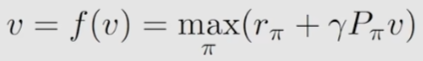

在上一个lecture中，介绍了`contration mapping theorem`，采用了迭代求解法：

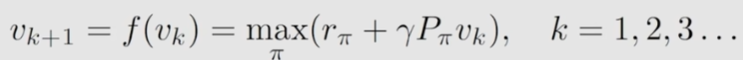

其中，$v_0$是随机给定。

实际上，这个算法就被称为`value iteration`

算法的更新包含两个步骤：

Step 1: policy update. 根据 $v_k$ ，求解 $\pi$ 

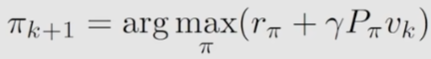 

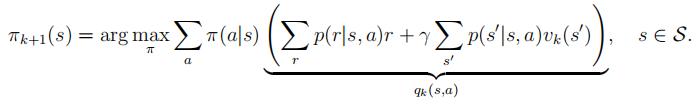

Step 2: 把步骤1中求解的 $\pi_{k+1}$ 带入下式，进行value update.

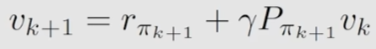

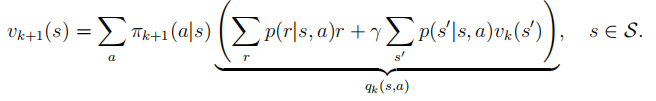

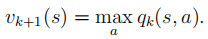

注意：更新时，$v_k$ 并不是state value，因为迭代过程中它并不满足贝尔曼方程（多次迭代后，结果逼近满足贝尔曼方程的 $v_k$ 值）

In summary, 上述过程总结如下：  

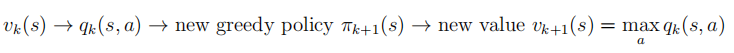

>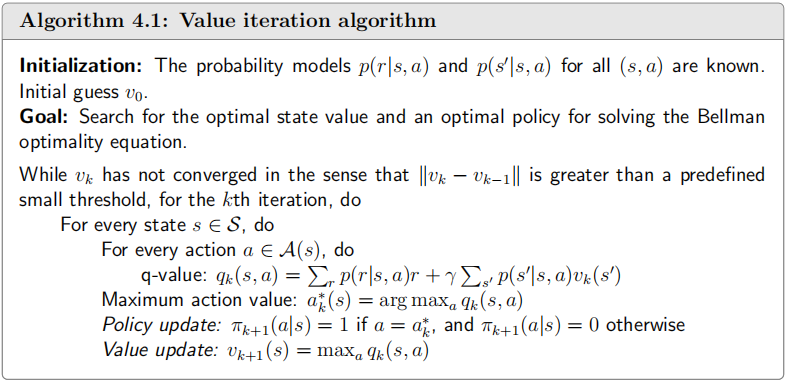

In [ ]:
import numpy as np
import pandas as pd

''' 
值迭代算法，伪代码见上图 Algorithm 4.1
Input:
    stateSpace: 状态空间 例如 ['s1', 's2', ..., 'sn']
    actionSpace: 动作空间 例如 ['up', 'right', ..., 'None']
    P_r: 奖励矩阵，字典形式表示 P_r[s][a] = {reward1: prob1, reward2: prob2, ...}
    P_s: 状态转移概率矩阵，字典形式表示 P_s[s][a] = {s_next1: prob1, s_next2: prob2, ...}
    threshold: 收敛阈值
    gamma: 折扣因子
Output:
    pi_list: 最终策略pi迭代序列
    v_list: 状态值v迭代序列
'''
def value_iteration_algorithm(stateSpace, actionSpace, P_r, P_s, threshold=1e-5, gamma=0.9):
    
    # 初始化v
    v = {}
    for s in stateSpace:
        v[s] = 0.0

    # 初始化策略PI
    pi = {}
    for s in stateSpace:
        pi[s] = np.random.choice(actionSpace)
    
    v_change = float('inf') # 初始化值变化量为无穷大
    max_steps = 1000 # 最大迭代步数
    step = 0

    q_sa = pd.DataFrame(0, index=stateSpace, columns=actionSpace) # 初始化q(s,a)
    
    v_list = [] # 状态值迭代序列
    pi_list = [] # 策略迭代序列

    while v_change > threshold or step >= max_steps:
        v_old = v.copy() # 记录上一次的状态值

        for s in stateSpace:  # 对每个状态s进行更新
            for a in actionSpace:  # 对每个动作a计算q(s,a)
                immediate_reward = sum(reward * prob for reward, prob in P_r[s][a].items())
                future_reward = gamma * sum(prob * v[s_next] for s_next, prob in P_s[s][a].items())
                q_sa.loc[s, a] = immediate_reward + future_reward
            # 选择使q(s,a)最大的动作作为当前状态s的最优动作
            v[s] = np.max(q_sa.loc[s, :]) # 更新状态值v_{k+1} = max_a q(s,a)

            # 策略其实可以不更新，仅在最后根据v计算最优策略即可，但这里为了记录迭代过程也进行更新
            pi[s] = actionSpace[np.random.choice(np.where(q_sa.loc[s, :] == v[s])[0])]  # 若有多个最优动作，随机选择一个
                
        v_list.append(v.copy()) # 记录当前状态值v
        pi_list.append(pi.copy()) # 记录当前策略pi
                
        v_change = np.abs(np.array(list(v.values())) - np.array(list(v_old.values()))).max() # 计算值变化量
        step += 1

    return pi_list, v_list

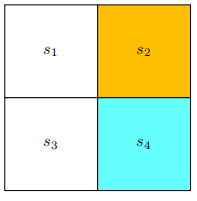  

以该图为例，奖励矩阵 $p(r|s, a)$和状态转移概率矩阵 $p(s'|s, a)$ 如下

In [18]:
''' 
奖励概率 p(r | s, a) 的表示形式
P_r = {
    s: { 
        a: {
          r1: prob1,
          r2: prob2,
          ...  
        }   
    }
}
'''
r_boundary = r_forbidden = -1
r_target = 1

P_r_ex1 = {
    's1': { 
        'up':    {r_boundary: 1}, # 状态 s1 动作 'up' 后 概率1 获得奖励 -1，
        'right': {r_forbidden: 1},
        'down':  {0: 1},
        'left':  {r_boundary: 1},
        'None':  {0: 1}
    },
    's2': {
        'up':    {r_boundary: 1}, 
        'right': {r_boundary: 1},
        'down':  {r_target: 1},
        'left':  {0: 1},
        'None':  {r_forbidden: 1}
    },
    's3': {
        'up':    {0: 1}, 
        'right': {r_target: 1},
        'down':  {r_boundary: 1},
        'left':  {r_boundary: 1},
        'None':  {0: 1}
    },
    's4': {
        'up':    {r_forbidden: 1}, 
        'right': {r_boundary: 1},
        'down':  {r_boundary: 1},
        'left':  {0: 1},
        'None':  {r_target: 1}
    }
}

''' 
状态转移概率 p(s' | s, a) 的表示形式 
P_s = {
    s: { 
        a: {
          s_next1: prob1,
          s_next2: prob2,
          ...  
        }   
    }
}
'''
P_s_ex1 = {
    's1': { 
        'up':    {'s1': 1}, 
        'right': {'s2': 1},
        'down':  {'s3': 1},
        'left':  {'s1': 1},
        'None':  {'s1': 1}
    },
    's2': {
        'up':    {'s2': 1}, 
        'right': {'s2': 1},
        'down':  {'s4': 1},
        'left':  {'s1': 1},
        'None':  {'s2': 1}
    },
    's3': {
        'up':    {'s1': 1}, 
        'right': {'s4': 1},
        'down':  {'s3': 1},
        'left':  {'s3': 1},
        'None':  {'s3': 1}
    },
    's4': {
        'up':    {'s2': 1}, 
        'right': {'s4': 1},
        'down':  {'s4': 1},
        'left':  {'s3': 1},
        'None':  {'s4': 1}
    }
}


In [20]:
stateSpace = ['s1', 's2', 's3', 's4'] # 状态空间s1, s2, s3, s4
actionSpace = ['up', 'right', 'down', 'left', 'None'] # 动作空间：上、右、下、左、保持不动

pi_list, v_list = value_iteration_algorithm(stateSpace, actionSpace, P_r_ex1, P_s_ex1, threshold=1e-5, gamma=0.9)
print("最终策略pi：", pi_list[-1])

最终策略pi： {'s1': 'down', 's2': 'down', 's3': 'right', 's4': 'None'}


最终策略： 

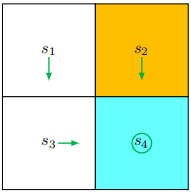

显然正确

**policy iteration algorithm**  

算法描述：  

Given a random initial policy $\pi_0$  

Step 1: policy evaluation. 求解贝尔曼公式，评估当前策略，计算state value  

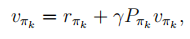

其中 $\pi_k$ 给定，$r_{\pi_k}$ 和 $P_{\pi_k}$ 由system model可知，因此可计算该策略下 $\pi_k$ 的state value $v_{\pi_k}$. 注意这一步需要迭代求解。

Step 2: policy improvement. 基于上一步计算的策略 $\pi_k$ 对应的state value $v_{\pi_k}$，可得到该state value对应的新策略 $\pi_{k+1}$ .

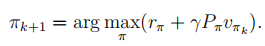  

In summary, 上述过程总结如下：  

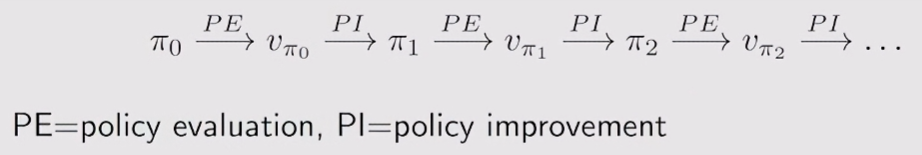

>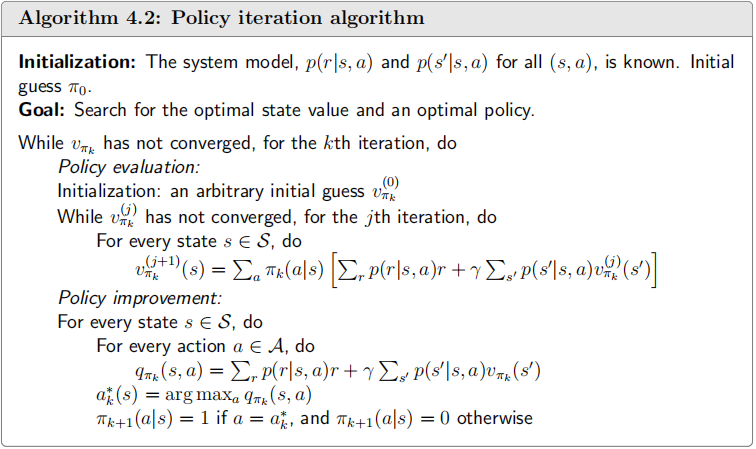


对比`值迭代算法`和`策略迭代算法`  

|    | 值迭代算法 | 策略迭代算法 |
|:---|-----------|-------------|
|算法思想| 初始化价值 $v_0$ ，然后计算 $v_0$ 时的最优策略 $\pi_1$ ；<br> 接着基于 $\pi_1$ 可计算 $v_1$，根据 $v_1$ 可计算此时的最优策略 $\pi_2$，...，不停迭代 | 初始化策略 $\pi_0$, 然后求解贝尔曼公式得到对应的state value $v_1$ ；<br> 接着基于 $v_1$ 可得到对应的最佳策略 $\pi_1$，...，不停迭代 |
|算法步骤| ① 策略更新：根据 $v_k$，求解 $\pi_{k+1}$. <br> 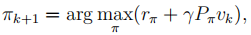 <br> ② 值更新：根据 $\pi_{k+1}$，求解 $v_{k+1}$ <br> 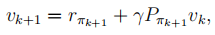| ① 策略评估：根据 $\pi_k$，求解贝尔曼公式得到 $v_{\pi_k}$. <br> 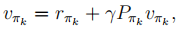 <br> ② 策略改进：基于 $v_{\pi_k}$，得到新策略 $\pi_{k+1}$ <br> 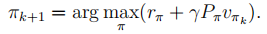|
|直观理解| 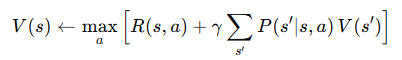 <br> - 尝试所有的动作 $a$ <br> - 选一个能让未来价值最大的动作 <br> - 用它来更新状态价值 | - 先假设有一个策略 $\pi$ <br> - 评估：这个策略到底好不好（计算这个策略下每个状态的价格）<br> 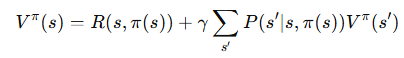 - 改进：在每个状态选一个更好的动作 <br> 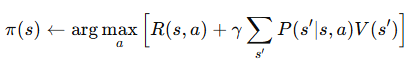|
|比喻| 先算“每个地方值多少钱”，再决定怎么走 | 先定一条走法 → 评估这条路好不好 → 换一条更好的 → 反复直到不能再改|

可以发现，值迭代和策略迭代都是针对转移概率P已知的情况，我们称这类方法为`model based`。但是在现实生活中还存在很多转移概率P位置的模型，只能通过环境反馈来估计得到，这类方法称为`model free`.